In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt


import ast

import json
from sklearn.tree import plot_tree
import stable_baselines3

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs


    

def load_data(prefix, traffic):
    with open(f"{META_FOLDER}/{traffic}.json") as f:
        meta_data = json.load(f)
    def translate_action(action_dict):
        # TODO: add fix in evaluate script
        action_dict = ast.literal_eval(action_dict)
        if not isinstance(action_dict, dict):
            action_dict = {"t": action_dict[0]}
        green = []
        for tf_id, p in action_dict.items():
            green_tf = f"{tf_id}:"
            green_tf += ", ".join(meta_data[tf_id]["phases"][str(p)]["lanes_green"])
            green.append(green_tf)
        return "; ".join(green)
    print("Loading", f'{EVAL_FOLDER}/{prefix}_{traffic}_1_episode.csv')
    df_single_episode = pd.read_csv(f'{EVAL_FOLDER}/{prefix}_{traffic}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    df_single_episode["translated_action"]= df_single_episode['action'].apply(
        lambda x: translate_action(x)
    )
    
    
    df_multiple_episodes = pd.read_csv(f'{EVAL_FOLDER}/{prefix}_{traffic}_100_episode.csv')
    df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    return df_single_episode, df_multiple_episodes

def compare_datasets(datasets):
    results = []
    for name, df in datasets:
        data = {
            'dataset': name,
            'avg_cumulative_reward': np.mean(df.cumulative_reward.to_list()),
            # 'mean_waiting_time': np.mean(df.mean_waiting_time.to_list()),
            
            'avg_travel_time': np.mean(df.avg_travel_time.to_list()),
            'avg_time_loss': np.mean(df.avg_time_loss.to_list()),
            'avg_waiting_time': np.mean(df.avg_waiting_time.to_list()),

            'collisions': np.mean(df.collisions.to_list()),
            'emergency_braking': np.mean(df.emergency_braking.to_list()),
            'emergency_stops': np.mean(df.emergency_stops.to_list()),

#             'mean_speed': np.mean(df.mean_speed.to_list()),
            'mean_lane_density': np.mean(df.mean_lane_density.to_list()),
            'mean_queue': np.mean(df.mean_queue_length.to_list()),

        }
        results.append(data)
    return pd.DataFrame(results)


def get_obs(df, index, traffic):
    total_observation = []
    unnested_obs = {}
    
    with open(f"{META_FOLDER}/{traffic}.json") as f:
        meta_data = json.load(f)
    
    for tf_id, observation_dict in json.loads(df.obs.to_list()[index]).items():        
        phase_ids = observation_dict["current_phase_ids"]
        # min_green = observation_dict["min_green"]
        # density = observation_dict["density"]
        queue = observation_dict["queue"]
        # queue_der = observation_dict["queue_der"]
        # average_speed = observation_dict["average_speed"]
        waiting_times = []
        for waiting_time in observation_dict["waiting_times"]:
            if waiting_time:
                waiting_times.append(np.max(waiting_time))
            else:
                waiting_times.append(0)
        observation = np.array(phase_ids + queue + waiting_times, dtype=np.float32)
        
        # TODO: check if I can update the phase ids?
        # TODO: double check queue_der
        tf_meta_data = meta_data[tf_id]        
        
        total_observation.extend(observation)
        for key, value in observation_dict.items():
            if key in ["current_phase_ids", "queue", "waiting_times"]:
                if isinstance(value, list):
                    for index, item in enumerate(value):
                        suffix = index
                        if key in ["queue", "waiting_times"]:
                            suffix = tf_meta_data["lanes"]["cleaned_incoming"][str(index)]
                        if key == "waiting_times":
                            if item:
                                item = np.max(item)
                            else:
                                item = 0
                        unnested_obs[f"{tf_id}_{key}_{suffix}"] = item
                else:
                    unnested_obs[f"{tf_id}_{key}"] = value
    total_observation = np.array(total_observation, dtype=np.float32)    


    return total_observation, unnested_obs

def __get_action_distribution(obs, policy_model):
    """Get the action distribution for the given state and option.

    Args:
        state: State to calculate the action distribution for.
        model: Model to calculate the action distribution with.
        option: Option to calculate the action distribution for.

    Returns:
        array: Numpy array with the action distribution.
    """
    state = {}
    for key, observation_dict in obs.items():
        phase_ids = observation_dict["hist_phase_ids"]
        queue = observation_dict["queue"]
        queue_der = observation_dict["queue_der"]
        average_speed = observation_dict["average_speed"]
        waiting_times = []
        for waiting_time in observation_dict["waiting_times"]:
            if waiting_time:
                waiting_times.append(np.mean(waiting_time))
            else:
                waiting_times.append(0)
        combined_obs = np.array(phase_ids + queue + queue_der + waiting_times + [average_speed], dtype=np.float32)
        state[key] = torch.tensor([combined_obs], dtype=torch.float32, device="cuda")
    return policy_model.get_distribution(state).distribution[0].probs.cpu().detach().numpy()[0]


def hellinger_distance(state, model_1, model_2) -> float:
    """Calculate the hellinger distance between the intra-option policies of the model
    for the given state.
    This as defined in the paper "Disentangling Options with Hellinger Distance Regularizer"

    Args:
        states: The states for which to calculate the hellinger distance.
        model: The option critic model to calculate the distance for.

    Returns:
        float: Helling distance loss
    """
    p_dist = __get_action_distribution(state, model_1.policy)
    q_dist = __get_action_distribution(state, model_2.policy)
    summation = np.sum((np.sqrt(p_dist) - np.sqrt(q_dist)) ** 2)
    hd = math.sqrt(summation) / math.sqrt(2)
    return hd


In [5]:
EVAL_FOLDER = '../evaluations'
META_FOLDER = "../meta"
MODELS_FOLDER = "../models"

In [6]:
# A2C models experiment 1: High and low traffic scenarios
MODEL_HIGH = "a2c_custom-2way-single-intersection-high_100000_stepsintelli_light_reward_delay_3_waiting_time_3_light_switches_2"
MODEL_LOW = "a2c_custom-2way-single-intersection-low_100000_stepsintelli_light_reward_delay_3_waiting_time_3_light_switches_2"

In [ ]:
# A2C models experiment 2: Broken traffic light scenario
MODEL_HIGH = "a2c_3x3grid-3lanes2_250000_stepsintelli_light_prcol_rewarddelay_3_waiting_time_3_light_switches_2_out_lanes_availability_1"  # "a2c_custom-2way-single-intersection-high_100000_steps"
MODEL_LOW = "a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_rewarddelay_3_waiting_time_3_light_switches_2_out_lanes_availability_1" # "a2c_custom-2way-single-intersection-low_100000_steps"

In [7]:
model_high = stable_baselines3.A2C.load(
    f"{MODELS_FOLDER}/{MODEL_HIGH}.zip"
)

model_low = stable_baselines3.A2C.load(
    f"{MODELS_FOLDER}/{MODEL_LOW}.zip"
)

/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() takes at most 16 arguments (18 given)
  warnings.warn(


Loading ../evaluations/a2c_custom-2way-single-intersection-low_100000_stepsintelli_light_reward_delay_3_waiting_time_3_light_switches_2_custom-2way-single-intersection-low_1_episode.csv
Test Accuracy: 0.90


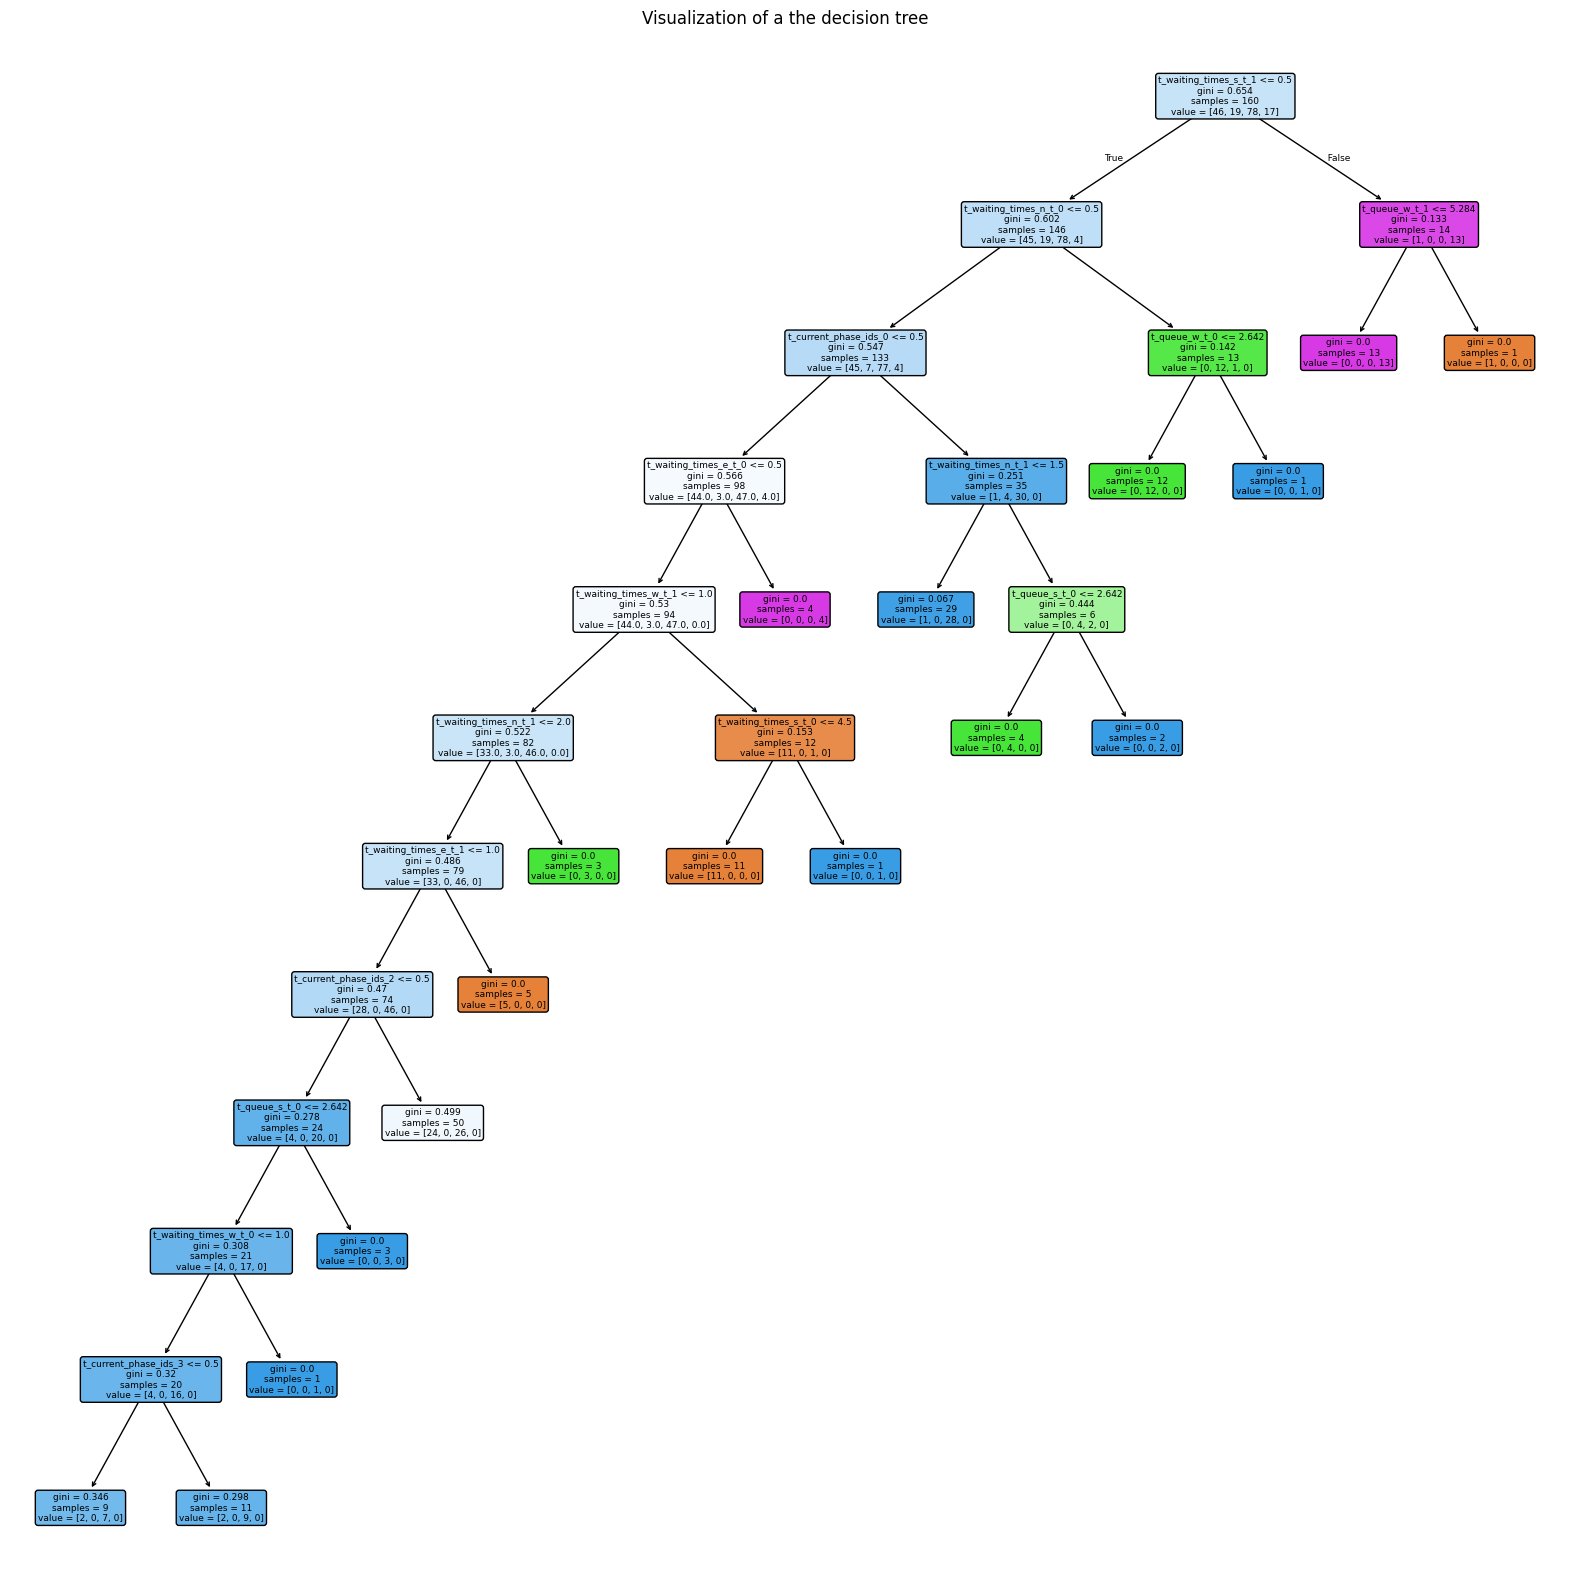

In [8]:
traffic = "custom-2way-single-intersection-low"
df_single_episode_high, _ = load_data(MODEL_LOW, traffic)

results = []
for index in range(df_single_episode_high.shape[0]):
    obs, unnested_dict = get_obs(df_single_episode_high, index, traffic)
    unnested_dict["action"] = model_low.predict({"t": obs})[0][0]
    keys = [key for key in unnested_dict if "min_green" in key]
    for key in keys:
        _ = unnested_dict.pop(key)
    results.append(unnested_dict)
df_actions = pd.DataFrame(results)

X = df_actions.loc[:, df_actions.columns != 'action'] # Select all columns except the option column
y = df_actions.loc[:, df_actions.columns == 'action']   # Select only the option column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(max_depth=15, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot the decision tree
plt.figure(figsize=(20, 20))
plot_tree(clf, feature_names=X.columns, filled=True, rounded=True)
plt.title("Visualization of a the decision tree")
plt.show()

In [1]:
traffic = "custom-2way-single-intersection-low"
df_single_episode_high, _ = load_data(MODEL_HIGH, traffic)

results = []
for index in range(df_single_episode_high.shape[0]):
    obs, unnested_dict = get_obs(df_single_episode_high, index, traffic)
    unnested_dict["action"] = model_low.predict({"t": obs})[0][0]
    keys = [key for key in unnested_dict if "min_green" in key]
    for key in keys:
        _ = unnested_dict.pop(key)
    results.append(unnested_dict)
df_actions = pd.DataFrame(results)

X = df_actions.loc[:, df_actions.columns != 'action'] # Select all columns except the option column
y = df_actions.loc[:, df_actions.columns == 'action']   # Select only the option column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(max_depth=15, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot the decision tree
plt.figure(figsize=(20, 20))
plot_tree(clf, feature_names=X.columns, filled=True, rounded=True)
plt.title("Visualization of a the decision tree")
plt.show()

NameError: name 'load_data' is not defined

NameError: name 'plt' is not defined